In [6]:
!rm -r images
!rm -r masks

In [1]:
%load_ext autoreload
%autoreload 2

import cv2
import torch.optim as optim
from torch.utils.data import  DataLoader

import segmentation_models_pytorch as smp
import albumentations as A

from config import CFG
from Dataset import BuildDatasetParts
from scripts.Models.utils import set_seed
from scripts.Models.Trainer import Trainer
from scripts.Models.Dataset import BuildDataset
from scripts.Models.ModelBuilder import ModelBuilder
from scripts.Models.Metrics import dice_coef, iou_coef

In [2]:
def prepare_loaders():
    print("Video processing....")

    print("*********  Creating datasets  *********")
    train_dataset = BuildDatasetParts(data_transforms["train"], CFG)
    valid_dataset = BuildDatasetParts(data_transforms["valid"], CFG)
    print("*********  Creating datasets DONE  *********")

    print("********* Creating data loaders *********")
    train_dataloader = DataLoader(train_dataset, batch_size=CFG.train_bs,
                                  num_workers=2, shuffle=True, pin_memory=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size=CFG.train_bs,
                                  num_workers=2, shuffle=False, pin_memory=True)
    print("********* Creating data loaders DONE *********")

    return train_dataset, valid_dataset, train_dataloader, valid_dataloader

In [3]:
set_seed()

In [4]:
data_transforms = {
    "train": A.Compose([
#                         A.HorizontalFlip(p=0.5),
#                         A.VerticalFlip(p=0.5),
                        # A.Resize(*CFG.img_size, interpolation=cv2.INTER_NEAREST),
                        A.Normalize(),
                        A.PadIfNeeded(CFG.img_size[0], CFG.img_size[1],
                                                      position = A.transforms.PadIfNeeded.PositionType.BOTTOM_RIGHT,
                                                      border_mode = cv2.BORDER_CONSTANT,
                                                      value=0, mask_value=0),
                        A.Affine(translate_percent=(0.1, 0.1)),
                        ], p=1.0),
    
    "valid": A.Compose([
        A.Resize(*CFG.img_size, interpolation=cv2.INTER_NEAREST),
        A.Normalize()
        ], p=1.0)
}

In [5]:
train_dataset, valid_dataset, train_dataloader, valid_dataloader = prepare_loaders()

Video processing....
*********  Creating datasets  *********
*********  Creating datasets DONE  *********
********* Creating data loaders *********
********* Creating data loaders DONE *********


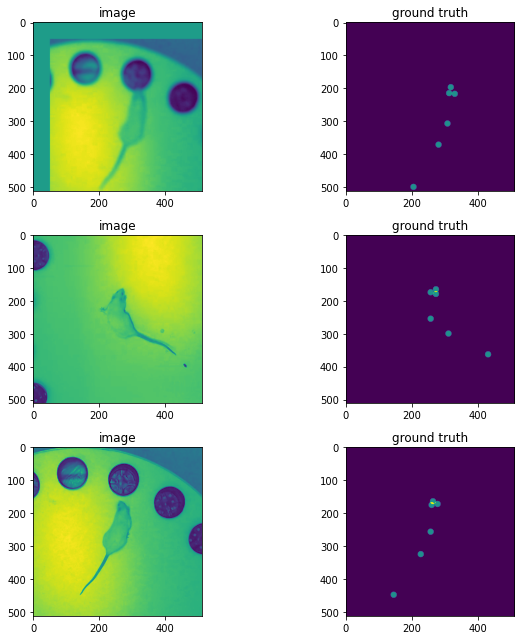

In [6]:
BuildDataset.show_batch_examples(train_dataset, 3)

In [7]:
model_builder = ModelBuilder(CFG, use_my_model=True, pretrained_model_path=None)

model_pytorch = model_builder.get_model()

In [8]:
optimizer = optim.Adam(model_pytorch.parameters(), lr=CFG.lr, weight_decay=CFG.wd)

BCELoss = smp.losses.SoftBCEWithLogitsLoss()
TverskyLoss = smp.losses.TverskyLoss(mode='multilabel', log_loss=False)
def criterion(y_pred, y_true):
    return 0.5*BCELoss(y_pred, y_true) + 0.5*TverskyLoss(y_pred, y_true)

loss_fn = criterion
dice_loss = dice_coef
iou_loss  = iou_coef

# Run Training

In [9]:
model_trainer = Trainer(model_pytorch, train_dataloader, valid_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        dice_loss=dice_loss,
                        iou_loss=iou_loss,
                        config=CFG)

In [1]:
model_trainer.run_training()

# Result

In [4]:
model_trainer.plot_logs()

In [5]:
model_trainer.show_result(valid_dataset, 6)